<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center> Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


<font color='red'>**Задание:**</font> заполните код в этой тетрадке и выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4). 

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = '~/capstone_user_identification'

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [3]:
rrr = pickle.load(open('save3.p', "rb"))

In [4]:
y_10users = pickle.load(open('saveuser3.p', "rb"))
X_sparse_10users = rrr[:, range(1, 4914)]

In [5]:
len(y_10users), X_sparse_10users.shape[1]

(14061, 4913)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [6]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

In [8]:
y_train.reset_index(drop = True, inplace = True)
y_valid.reset_index(drop = True, inplace = True)

In [9]:
print(X_train[6,:])

  (0, 7)	7
  (0, 0)	3


**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [10]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [11]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [12]:
from sklearn.neighbors import KNeighborsClassifier

In [13]:
knn = KNeighborsClassifier(n_jobs=-1, n_neighbors=100)
cross_val_score(knn,
                X=X_train,
                y=y_train,
                cv=skf).mean()

0.56471888700633621

In [14]:
ah=knn.predict(X_valid)

NotFittedError: Must fit neighbors before querying.

In [14]:
knn = KNeighborsClassifier(n_jobs=-1)
sss = GridSearchCV(knn, {'n_neighbors':[100]}, cv = skf)

In [15]:
sss.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [16]:
sss.best_score_

0.56472261735419627

In [17]:
modres1=sss.predict(X_valid)

In [18]:
from sklearn.metrics import accuracy_score
accuracy_score(modres1, y_valid)

0.58402465039108797

In [21]:
import sklearn
sklearn.__version__

'0.19.1'

**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [ ]:
#0.565, 0.584

**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
forest = RandomForestClassifier(n_jobs=-1, random_state=17, oob_score=True, n_estimators=100)
for train_index, test_index in skf.split(X_train, y_train):
    #print(X_train[train_index,:])
    #print(y_train[train_index])
    forest.fit(X_train[train_index, :], y_train[train_index])
    print(forest.score(X_train[test_index, :], y_train[test_index]))
    print(forest.oob_score_)

0.704109589041
0.71175842611
0.720036596523
0.700594240439
0.716900549115
0.698659354052


In [24]:
forest = RandomForestClassifier(n_jobs=-1, random_state=17, oob_score=True)
sss2 = GridSearchCV(forest, {'n_estimators':[100]}, cv = skf)

In [25]:
sss2.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=True, random_state=17, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [26]:
modres2 = sss2.predict(X_valid)
print(accuracy_score(modres2, y_valid))
sss2.best_score_
#sss2.cv_results_
###0.704, 0.733

0.732638065892


0.71367608209713473

**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [17]:
write_answer_to_file(''' ВАШ КОД ЗДЕСЬ ''',
                     'answer4_2.txt')

NameError: name 'write_answer_to_file' is not defined

In [18]:
!cat answer4_2.txt

"cat" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [27]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [28]:
logit = LogisticRegression()
mod = GridSearchCV(logit, {'random_state':[17]}, cv=skf, n_jobs=-1)
mod.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'random_state': [17]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [29]:
accuracy_score(mod.predict(X_valid), y_valid), mod.best_score_

(0.78170182507703245, 0.76102418207681366)

**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [30]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs = logit_c_values1, multi_class='multinomial', random_state=17, cv = skf, n_jobs=-1)
logit_grid_searcher1.fit(X_train, y_train)

Wall time: 15.3 s


In [31]:
vals = (logit_grid_searcher1.scores_[31][0] + logit_grid_searcher1.scores_[31][1] + logit_grid_searcher1.scores_[31][2])/3

In [32]:
vals

array([ 0.31822225,  0.47337913,  0.55273512,  0.65119285,  0.71297117,
        0.75137565,  0.75930066,  0.75706721,  0.74954975,  0.73949137])

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [33]:
ah = []
for key in logit_grid_searcher1.scores_.keys():
    print(key)
    ah.append(logit_grid_searcher1.scores_[key].mean())

128
33
50
100
39
241
127
237
207
31


In [34]:
logit_grid_searcher1.scores_

{31: array([[ 0.32511416,  0.47305936,  0.54885845,  0.64414003,  0.70197869,
          0.74398782,  0.75251142,  0.74764079,  0.73820396,  0.72754947],
        [ 0.32662397,  0.47819457,  0.56084172,  0.66056725,  0.72766087,
          0.76395242,  0.76974687,  0.76761208,  0.76029277,  0.74900884],
        [ 0.30292862,  0.46888347,  0.54850519,  0.64887126,  0.70927395,
          0.7461867 ,  0.75564369,  0.75594875,  0.75015253,  0.7419158 ]]),
 33: array([[ 0.32511416,  0.47305936,  0.54885845,  0.64414003,  0.70197869,
          0.74398782,  0.75251142,  0.74764079,  0.73820396,  0.72754947],
        [ 0.32662397,  0.47819457,  0.56084172,  0.66056725,  0.72766087,
          0.76395242,  0.76974687,  0.76761208,  0.76029277,  0.74900884],
        [ 0.30292862,  0.46888347,  0.54850519,  0.64887126,  0.70927395,
          0.7461867 ,  0.75564369,  0.75594875,  0.75015253,  0.7419158 ]]),
 39: array([[ 0.32511416,  0.47305936,  0.54885845,  0.64414003,  0.70197869,
          0.7439

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [35]:
vals, logit_c_values1

(array([ 0.31822225,  0.47337913,  0.55273512,  0.65119285,  0.71297117,
         0.75137565,  0.75930066,  0.75706721,  0.74954975,  0.73949137]),
 array([  1.00000000e-04,   4.64158883e-04,   2.15443469e-03,
          1.00000000e-02,   4.64158883e-02,   2.15443469e-01,
          1.00000000e+00,   4.64158883e+00,   2.15443469e+01,
          1.00000000e+02]))

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

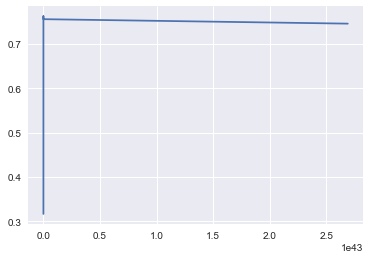

In [77]:
plt.plot(np.exp(logit_c_values1), vals);

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(3, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [36]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs = logit_c_values2, multi_class='multinomial', random_state=17, cv = skf, n_jobs=-1, scoring = 'accuracy')
logit_grid_searcher2.fit(X_train, y_train)

Wall time: 44.3 s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [37]:
vals2 = (logit_grid_searcher2.scores_[31][0] + logit_grid_searcher2.scores_[31][1] + logit_grid_searcher2.scores_[31][2])/3

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [38]:
vals2, logit_c_values2

(array([ 0.7354267 ,  0.75889304,  0.7584878 ,  0.75767446,  0.75798001,
         0.75808238,  0.75787922,  0.75737171,  0.75696561,  0.75686494,
         0.75716942,  0.75676347,  0.75595093,  0.75564645,  0.75534235,
         0.75463168,  0.75463233,  0.75463236,  0.7544292 ,  0.75381935]),
 array([ 0.1       ,  0.46315789,  0.82631579,  1.18947368,  1.55263158,
         1.91578947,  2.27894737,  2.64210526,  3.00526316,  3.36842105,
         3.73157895,  4.09473684,  4.45789474,  4.82105263,  5.18421053,
         5.54736842,  5.91052632,  6.27368421,  6.63684211,  7.        ]))

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

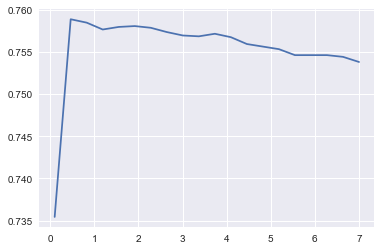

In [39]:
plt.plot(logit_c_values2, vals2);

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [40]:
logit_cv_acc = accuracy_score(logit_grid_searcher2.predict(X_valid), y_valid)

In [41]:
logit_cv_acc

0.7748281583313581

**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [35]:
#0.76, 0.779  #### 0.759  0.775

**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [47]:
from sklearn.svm import LinearSVC

In [48]:
svm = LinearSVC(random_state=17)
mod = GridSearchCV(svm, {'C':[1]}, cv = skf)
mod.fit(X_train, y_train)
mod.best_score_, accuracy_score(mod.predict(X_valid), y_valid)

(0.75279414753098961, 0.77696136525242954)

**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [49]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, svm_params1, cv = skf)
svm_grid_searcher1.fit(X_train, y_train)

Wall time: 49.8 s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [50]:
svm_grid_searcher1.best_score_, accuracy_score(svm_grid_searcher1.predict(X_valid), y_valid)

(0.68451534241007927, 0.70087698506755158)

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

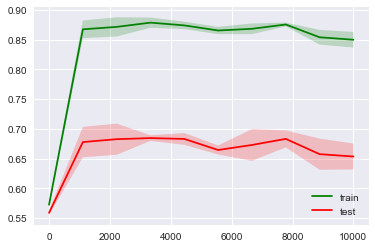

In [51]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [52]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, svm_params2, cv = skf)
svm_grid_searcher2.fit(X_train, y_train)

Wall time: 1min 26s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [53]:
svm_grid_searcher2.best_score_, svm_grid_searcher2.best_params_

(0.76468197520829095, {'C': 0.10434482758620689})

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

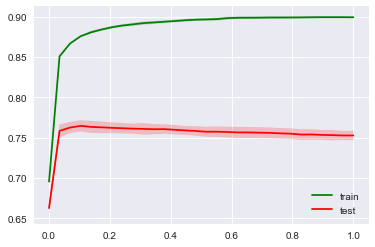

In [54]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [55]:
svm_cv_acc = accuracy_score(svm_grid_searcher2.predict(X_valid), y_valid)

**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [56]:
svm_grid_searcher2.best_score_, svm_cv_acc

(0.76468197520829095, 0.78075373311211183)

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [96]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    X = pickle.load(open(path_to_X_pickle, "rb"))
    y = pickle.load(open(path_to_y_pickle, "rb"))
    print(X.shape, len(y))
    #Z=X[:, range(1, X.shape[1])]
    #X = Z
    print(X.shape, len(y))
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=test_size, 
                                                     random_state=random_state, stratify=y)
    model = GridSearchCV(estimator, {}, cv = cv)
    model.fit(X_train, y_train)
    res1 = model.best_score_
    vec = model.predict(X_valid)
    res2 = accuracy_score(vec, y_valid)
    estimator.fit(X_train, y_train)
    vec = estimator.predict(X_valid)
    res3 = accuracy_score(vec, y_valid)
    return(res1, res2, res3, '!!!')
    #res1 = (cross_val_score(knn,
    #            X=X,
    #            y=y,
    #            cv=cv)).mean()
    

In [95]:
model_assessment(svm_grid_searcher2.best_estimator_, 'save3.p', 'saveuser3.p', skf, random_state=17, test_size=0.3)

(14061, 4914) 14061
(14061, 4914) 14061


TypeError: __init__() got an unexpected keyword argument 'njobs'

**Убедитесь, что функция работает.**

In [195]:
print(model_assessment(svm_grid_searcher2.best_estimator_, 
                 'save2.p', 'saveuser2.p', skf, random_state=17, test_size=0.3))
print(model_assessment(svm_grid_searcher2.best_estimator_, 
                 'save3.p', 'saveuser3.p', skf, random_state=17, test_size=0.3))
print(model_assessment(svm_grid_searcher2.best_estimator_, 
                 'save4.p', 'saveuser4.p', skf, random_state=17, test_size=0.3))
print(model_assessment(svm_grid_searcher2.best_estimator_, 
                 'save5.p', 'saveuser5.p', skf, random_state=17, test_size=0.3))
print(model_assessment(svm_grid_searcher2.best_estimator_, 
                 'save6.p', 'saveuser6.p', skf, random_state=17, test_size=0.3))
print(model_assessment(svm_grid_searcher2.best_estimator_, 
                 'save7.p', 'saveuser7.p', skf, random_state=17, test_size=0.3))
print(model_assessment(svm_grid_searcher2.best_estimator_, 
                 'save8.p', 'saveuser8.p', skf, random_state=17, test_size=0.3))
print(model_assessment(svm_grid_searcher2.best_estimator_, 
                 'save9.p', 'saveuser9.p', skf, random_state=17, test_size=0.3))
print(model_assessment(svm_grid_searcher2.best_estimator_, 
                 'save10.p', 'saveuser10.p', skf, random_state=17, test_size=0.3))

(14061, 4913) 14061
(0.823816297500508, 0.84048352690210948, 0.84048352690210948, '!!!')
(14061, 4913) 14061
(0.76468197520829095, 0.78075373311211183, 0.78075373311211183, '!!!')
(20087, 4913) 20087
(0.84793741109530585, 0.85432221669155473, 0.85432221669155473, '!!!')
(20087, 4913) 20087
(0.79701280227596016, 0.80736684917869583, 0.80736684917869583, '!!!')
(20087, 4913) 20087
(0.75298719772403988, 0.76173884187821472, 0.76173884187821472, '!!!')
(28118, 4913) 28118
(0.86800121938827357, 0.87529634898055952, 0.87529634898055952, '!!!')
(28118, 4913) 28118
(0.81592317853876639, 0.82456140350877194, 0.82456140350877194, '!!!')
(28118, 4913) 28118
(0.77405751448023574, 0.78532479848269321, 0.78532479848269321, '!!!')
(28118, 4913) 28118
(0.72528198353825835, 0.73624940730203892, 0.73624940730203892, '!!!')


In [202]:
print(model_assessment(svm_grid_searcher2.best_estimator_, 
                 'save2.p', 'saveuser2.p', skf, random_state=17, test_size=0.3))
print(model_assessment(svm_grid_searcher2.best_estimator_, 
                 'save3.p', 'saveuser3.p', skf, random_state=17, test_size=0.3))
print(model_assessment(svm_grid_searcher2.best_estimator_, 
                 'save4.p', 'saveuser4.p', skf, random_state=17, test_size=0.3))
print(model_assessment(svm_grid_searcher2.best_estimator_, 
                 'save5.p', 'saveuser5.p', skf, random_state=17, test_size=0.3))
print(model_assessment(svm_grid_searcher2.best_estimator_, 
                 'save6.p', 'saveuser6.p', skf, random_state=17, test_size=0.3))
print(model_assessment(svm_grid_searcher2.best_estimator_, 
                 'save7.p', 'saveuser7.p', skf, random_state=17, test_size=0.3))
print(model_assessment(svm_grid_searcher2.best_estimator_, 
                 'save8.p', 'saveuser8.p', skf, random_state=17, test_size=0.3))
print(model_assessment(svm_grid_searcher2.best_estimator_, 
                 'save9.p', 'saveuser9.p', skf, random_state=17, test_size=0.3))
print(model_assessment(svm_grid_searcher2.best_estimator_, 
                 'save10.p', 'saveuser10.p', skf, random_state=17, test_size=0.3))

(14061, 4914) 14061
(14061, 4914) 14061
(0.82320666531192843, 0.83977245792841904, 0.83977245792841904, '!!!')
(14061, 4914) 14061
(14061, 4914) 14061
(0.76427555374923795, 0.78051671012088175, 0.78051671012088175, '!!!')
(20087, 4914) 20087
(20087, 4914) 20087
(0.847724039829303, 0.85399037663846022, 0.85399037663846022, '!!!')
(20087, 4914) 20087
(20087, 4914) 20087
(0.79715504978662877, 0.80720092915214869, 0.80720092915214869, '!!!')
(20087, 4914) 20087
(20087, 4914) 20087
(0.75277382645803703, 0.76157292185166747, 0.76157292185166747, '!!!')
(28118, 4914) 28118
(28118, 4914) 28118
(0.86764556447515495, 0.87494073020388807, 0.87494073020388807, '!!!')
(28118, 4914) 28118
(28118, 4914) 28118
(0.8156691393151102, 0.82373162636320529, 0.82373162636320529, '!!!')
(28118, 4914) 28118
(28118, 4914) 28118
(0.7739050909460421, 0.78520625889046947, 0.78520625889046947, '!!!')
(28118, 4914) 28118
(28118, 4914) 28118
(0.72523117569352713, 0.73589378852536746, 0.73589378852536746, '!!!')


In [56]:
print(model_assessment(svm_grid_searcher2.best_estimator_, 
                 'save7.p', 'saveuser7.p', skf, random_state=17, test_size=0.3))


(28118, 4914) 28118
(28118, 4914) 28118
(0.87135453714053446, 0.8771929824561403, 0.8771929824561403, '!!!')


**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [ ]:
!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 

In [ ]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = ''' ВАШ КОД ЗДЕСЬ '''
        path_to_y_pkl = ''' ВАШ КОД ЗДЕСЬ '''
        print           ''' ВАШ КОД ЗДЕСЬ '''

**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [ ]:
#0.868, 0.875

In [ ]:
print(model_assessment(svm_grid_searcher2.best_estimator_, 
                 'save11.p', 'saveuser11.p', skf, random_state=17, test_size=0.3))
print(model_assessment(svm_grid_searcher2.best_estimator_, 
                 'save12.p', 'saveuser12.p', skf, random_state=17, test_size=0.3))
print(model_assessment(svm_grid_searcher2.best_estimator_, 
                 'save13.p', 'saveuser13.p', skf, random_state=17, test_size=0.3))
print(model_assessment(svm_grid_searcher2.best_estimator_, 
                 'save14.p', 'saveuser14.p', skf, random_state=17, test_size=0.3))
print(model_assessment(svm_grid_searcher2.best_estimator_, 
                 'save15.p', 'saveuser15.p', skf, random_state=17, test_size=0.3))
print(model_assessment(svm_grid_searcher2.best_estimator_, 
                 'save16.p', 'saveuser16.p', skf, random_state=17, test_size=0.3))
print(model_assessment(svm_grid_searcher2.best_estimator_, 
                 'save17.p', 'saveuser17.p', skf, random_state=17, test_size=0.3))
print(model_assessment(svm_grid_searcher2.best_estimator_, 
                 'save18.p', 'saveuser18.p', skf, random_state=17, test_size=0.3))
print(model_assessment(svm_grid_searcher2.best_estimator_, 
                 'save19.p', 'saveuser19.p', skf, random_state=17, test_size=0.3))

(137019, 27798) 137019
(137019, 27798) 137019
(0.54902880735666693, 0.57507419841385687, 0.57507419841385687, '!!!')
(137019, 27798) 137019
(137019, 27798) 137019
(0.4611992117856808, 0.48367634895149125, 0.48367634895149125, '!!!')
(195712, 27798) 195712
(195712, 27798) 195712
(0.58397932816537468, 0.60852607555267912, 0.60852607555267912, '!!!')
(195712, 27798) 195712
(195712, 27798) 195712
(0.43632753762828652, 0.45297544026978231, 0.45297544026978231, '!!!')
(273957, 27798) 273957
(273957, 27798) 273957
(0.61389484223206048, 0.63619993186353241, 0.63619993186353241, '!!!')
(273957, 27798) 273957
(273957, 27798) 273957
(0.52493364412391996, 0.54596778118460121, 0.54596778118460121, '!!!')
(273957, 27798) 273957
(273957, 27798) 273957
(0.46486658427587357, 0.48179782936681753, 0.48179782936681753, '!!!')
(273957, 27798) 273957
(273957, 27798) 273957
(0.40860097304569559, 0.42175256728476179, 0.42175256728476179, '!!!')


In [97]:
print(model_assessment(svm_grid_searcher2.best_estimator_, 
                 'save12.p', 'saveuser12.p', skf, random_state=17, test_size=0.3))


(137019, 27798) 137019
(137019, 27798) 137019
(0.46021915694431415, 0.48421155062521287, 0.48421155062521287, '!!!')


In [ ]:
print(model_assessment(svm_grid_searcher2.best_estimator_, 
                 'save19.p', 'saveuser19.p', skf, random_state=17, test_size=0.3))

**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [ ]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    path_to_X_pkl = ''' ВАШ КОД ЗДЕСЬ '''
    path_to_y_pkl = ''' ВАШ КОД ЗДЕСЬ '''
    print           ''' ВАШ КОД ЗДЕСЬ '''

**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [ ]:
#0.461, 0.484

## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [98]:
y_150users = pickle.load(open('saveuser12.p', "rb"))
X_sparse_150users = pickle.load(open('save12.p', "rb"))
print(X_sparse_150users.shape)

(137019, 27798)


In [52]:
X_sparse_150users = X_sparse_150users[:, range(1, X_sparse_150users.shape[1])]

MemoryError: 

In [99]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [100]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=[3.42105263], multi_class='ovr', random_state=17, n_jobs=-1)
logit_cv_150users.fit(X_train_150, y_train_150)

Wall time: 11min 17s


**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [101]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    print('User ' +str(user_id) + ' CV score: ' + str(logit_cv_150users.scores_[user_id].mean()))

User 256 CV score: 0.995985927579
User 640 CV score: 0.99722681495
User 258 CV score: 0.995829450836
User 259 CV score: 0.994870323777
User 260 CV score: 0.997268605371
User 261 CV score: 0.989615727661
User 6 CV score: 0.995985556119
User 263 CV score: 0.992858026715
User 264 CV score: 0.996507222925
User 780 CV score: 0.99643422481
User 13 CV score: 0.996319699258
User 270 CV score: 0.989438473915
User 15 CV score: 0.995256195466
User 16 CV score: 0.991753182925
User 273 CV score: 0.994307213809
User 515 CV score: 0.994119604917
User 533 CV score: 0.993744413803
User 28 CV score: 0.990303414153
User 797 CV score: 0.995766941492
User 1054 CV score: 0.996486390685
User 31 CV score: 0.994150953546
User 1040 CV score: 0.99711207681
User 33 CV score: 0.993692229042
User 859 CV score: 0.998248155438
User 1798 CV score: 0.996611754164
User 294 CV score: 0.995621085249
User 39 CV score: 0.985997634085
User 298 CV score: 0.991252659742
User 812 CV score: 0.994703480312
User 301 CV score: 0.99

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [108]:
class_distr = np.bincount(y_train_150.astype('int'))

#print(len(class_distr[class_distr>0]), len(y_train_150.unique()))
class_distr = class_distr[class_distr>0]

vals = np.sort(y_train_150.unique())
print(vals[0:10])

print(class_distr.sum())

nums = []

for j in range(len(vals)):
    user = vals[j]
    prob = 1-class_distr[j]/class_distr.sum()
    real = logit_cv_150users.scores_[user].mean()
    if real > prob:
        nums.append(user)

[ 6 13 15 16 28 31 33 39 46 49]
95913


In [109]:
print(len(y_train_150), len(y_valid_150))

95913 41106


In [111]:
len(nums)/150, len(nums)

(0.8, 120)

In [ ]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()

**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ '''

**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [124]:
y_150users=pd.DataFrame(y_150users)

In [126]:
y_150users.columns

Index(['user_id'], dtype='object')

In [140]:
y_150users['bin'] = (1-abs(np.sign(y_150users.user_id - 128))) 

In [141]:
y_binary_128 = y_150users.bin.values

In [147]:
y_binary_128[y_binary_128>0]

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [144]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [145]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
#estimator = logit_cv_150users
n_train, val_train, val_test = learning_curve(estimator, X=X_sparse_150users, y=y_binary_128, train_sizes=train_sizes, n_jobs = -1)


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\Users\user\Anaconda3\lib\runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    179         sys.exit(msg)
    180     main_globals = sys.modules["__main__"].__dict__
    181     if alter_argv:
    182         sys.argv[0] = mod_spec.origin
    183     return _run_code(code, main_globals, None,
--> 184                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...da3\\lib\\site-packages\\ipykernel\\__main__.py')
    185 
    186 def run_module(mod_name, init_globals=None,
    187                run_name=None, alter_sys=False):
    188     """Execute a module's code without importing it

...........................................................................
C:\Users\user\Anaconda3\lib\runpy.py in _run_code(code=<code object <module> at 0x00000000011C9B70, fil...lib\site-packages\ipykernel\__main__.py", line 1>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__pycache__\__main__.cpython-35.pyc', '__doc__': None, '__file__': r'C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...da3\\lib\\site-packages\\ipykernel\\__main__.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\u...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...da3\\lib\\site-packages\\ipykernel\\__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x00000000011C9B70, fil...lib\site-packages\ipykernel\__main__.py", line 1>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__pycache__\__main__.cpython-35.pyc', '__doc__': None, '__file__': r'C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...da3\\lib\\site-packages\\ipykernel\\__main__.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\u...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    469             return self.subapp.start()
    470         if self.poller is not None:
    471             self.poller.start()
    472         self.kernel.start()
    473         try:
--> 474             ioloop.IOLoop.instance().start()
    475         except KeyboardInterrupt:
    476             pass
    477 
    478 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\tornado\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    882                 self._events.update(event_pairs)
    883                 while self._events:
    884                     fd, events = self._events.popitem()
    885                     try:
    886                         fd_obj, handler_func = self._handlers[fd]
--> 887                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    888                     except (OSError, IOError) as e:
    889                         if errno_from_exception(e) == errno.EPIPE:
    890                             # Happens when the client closes the connection
    891                             pass

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    271         if self.control_stream:
    272             self.control_stream.on_recv(self.dispatch_control, copy=False)
    273 
    274         def make_dispatcher(stream):
    275             def dispatcher(msg):
--> 276                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    277             return dispatcher
    278 
    279         for s in self.shell_streams:
    280             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': '%%time\ntrain_sizes = np.linspace(0.25, 1, 20)\nes...inary_128, train_sizes=train_sizes, n_jobs = -1)\n', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2017-10-21T01:55:49.181231', 'msg_id': 'F7EAB1798285484587F937D21EF1BB8C', 'msg_type': 'execute_request', 'session': '37B45472E14148B489DB2BEF40FBE841', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'F7EAB1798285484587F937D21EF1BB8C', 'msg_type': 'execute_request', 'parent_header': {}})
    223             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    224         else:
    225             self.log.debug("%s: %s", msg_type, msg)
    226             self.pre_handler_hook()
    227             try:
--> 228                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'37B45472E14148B489DB2BEF40FBE841']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': '%%time\ntrain_sizes = np.linspace(0.25, 1, 20)\nes...inary_128, train_sizes=train_sizes, n_jobs = -1)\n', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2017-10-21T01:55:49.181231', 'msg_id': 'F7EAB1798285484587F937D21EF1BB8C', 'msg_type': 'execute_request', 'session': '37B45472E14148B489DB2BEF40FBE841', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'F7EAB1798285484587F937D21EF1BB8C', 'msg_type': 'execute_request', 'parent_header': {}}
    229             except Exception:
    230                 self.log.error("Exception in message handler:", exc_info=True)
    231             finally:
    232                 self.post_handler_hook()

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'37B45472E14148B489DB2BEF40FBE841'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': '%%time\ntrain_sizes = np.linspace(0.25, 1, 20)\nes...inary_128, train_sizes=train_sizes, n_jobs = -1)\n', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2017-10-21T01:55:49.181231', 'msg_id': 'F7EAB1798285484587F937D21EF1BB8C', 'msg_type': 'execute_request', 'session': '37B45472E14148B489DB2BEF40FBE841', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'F7EAB1798285484587F937D21EF1BB8C', 'msg_type': 'execute_request', 'parent_header': {}})
    385         if not silent:
    386             self.execution_count += 1
    387             self._publish_execute_input(code, parent, self.execution_count)
    388 
    389         reply_content = self.do_execute(code, silent, store_history,
--> 390                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    391 
    392         # Flush output before sending the reply.
    393         sys.stdout.flush()
    394         sys.stderr.flush()

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='%%time\ntrain_sizes = np.linspace(0.25, 1, 20)\nes...inary_128, train_sizes=train_sizes, n_jobs = -1)\n', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = '%%time\ntrain_sizes = np.linspace(0.25, 1, 20)\nes...inary_128, train_sizes=train_sizes, n_jobs = -1)\n'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('%%time\ntrain_sizes = np.linspace(0.25, 1, 20)\nes...inary_128, train_sizes=train_sizes, n_jobs = -1)\n',), **kwargs={'silent': False, 'store_history': True})
    496             )
    497         self.payload_manager.write_payload(payload)
    498 
    499     def run_cell(self, *args, **kwargs):
    500         self._last_traceback = None
--> 501         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('%%time\ntrain_sizes = np.linspace(0.25, 1, 20)\nes...inary_128, train_sizes=train_sizes, n_jobs = -1)\n',)
        kwargs = {'silent': False, 'store_history': True}
    502 
    503     def _showtraceback(self, etype, evalue, stb):
    504         # try to preserve ordering of tracebacks and print statements
    505         sys.stdout.flush()

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='%%time\ntrain_sizes = np.linspace(0.25, 1, 20)\nes...inary_128, train_sizes=train_sizes, n_jobs = -1)\n', store_history=True, silent=False, shell_futures=True)
   2712                 self.displayhook.exec_result = result
   2713 
   2714                 # Execute the user code
   2715                 interactivity = "none" if silent else self.ast_node_interactivity
   2716                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2717                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2718                 
   2719                 self.last_execution_succeeded = not has_raised
   2720 
   2721                 # Reset this so later displayed values do not modify the

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>], cell_name='<ipython-input-145-5329c2c8319b>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at d611eb8, execution_co..._before_exec=None error_in_exec=None result=None>)
   2822                     return True
   2823 
   2824             for i, node in enumerate(to_run_interactive):
   2825                 mod = ast.Interactive([node])
   2826                 code = compiler(mod, cell_name, "single")
-> 2827                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x000000000D6654B0, file "<ipython-input-145-5329c2c8319b>", line 1>
        result = <ExecutionResult object at d611eb8, execution_co..._before_exec=None error_in_exec=None result=None>
   2828                     return True
   2829 
   2830             # Flush softspace
   2831             if softspace(sys.stdout, 0):

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x000000000D6654B0, file "<ipython-input-145-5329c2c8319b>", line 1>, result=<ExecutionResult object at d611eb8, execution_co..._before_exec=None error_in_exec=None result=None>)
   2876         outflag = 1  # happens in more places, so it's easier as default
   2877         try:
   2878             try:
   2879                 self.hooks.pre_run_code_hook()
   2880                 #rprint('Running code', repr(code_obj)) # dbg
-> 2881                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x000000000D6654B0, file "<ipython-input-145-5329c2c8319b>", line 1>
        self.user_global_ns = {'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'from __future__ import division, print_function\n...m sklearn.metrics import accuracy_score, f1_score', "# Поменяйте на свой путь к данным\nPATH_TO_DATA = '~/capstone_user_identification'", 'rrr = pickle.load(open(\'save3.p\', "rb"))', 'y_10users = pickle.load(open(\'saveuser3.p\', "rb"))\nX_sparse_10users = rrr[:, range(1, 4914)]', 'len(y_10users), X_sparse_10users.shape[1]', 'X_sparse_10users.shape', 'X_train, X_valid, y_train, y_valid = train_test_...             random_state=17, stratify=y_10users)', 'y_train.reset_index(drop = True, inplace = True)\ny_valid.reset_index(drop = True, inplace = True)', 'print(X_train[6,:])', 'skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)', 'def plot_validation_curves(param_values, grid_cv..._line[0].get_color(), alpha=0.2)\n    plt.legend()', 'from sklearn.neighbors import KNeighborsClassifier', 'knn = KNeighborsClassifier(n_jobs=-1, n_neighbor...        y=y_train,\n                cv=skf).mean()', 'ah=knn.predict(X_valid)', 'sss2.fit(X_train, y_train)', 'modres2 = sss2.predict(X_valid)\nprint(accuracy_s...ss2.best_score_\n#sss2.cv_results_\n###0.704, 0.733', "write_answer_to_file(''' ВАШ КОД ЗДЕСЬ ''',\n                     'answer4_2.txt')", "get_ipython().system('cat answer4_2.txt')", 'from sklearn.linear_model import LogisticRegression, LogisticRegressionCV', ...], 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'LinearSVC': <class 'sklearn.svm.classes.LinearSVC'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'LogisticRegressionCV': <class 'sklearn.linear_model.logistic.LogisticRegressionCV'>, 'Out': {5: (14061, 4913), 6: (14061, 4913), 13: 0.56167298405556676, 20: GridSearchCV(cv=StratifiedKFold(n_splits=3, rand...return_train_score=True, scoring=None, verbose=0), 21: (0.78170182507703245, 0.76254826254826258), 24: array([ 0.31679887,  0.47358573,  0.55476721,  0...76082208,  0.7622432 ,  0.75563934,  0.74558182]), 26: {31: array([[ 0.32724505,  0.46940639,  0.55190259,  ...6388041,  0.76357535,  0.75747407,  0.75228798]]), 33: array([[ 0.32724505,  0.46940639,  0.55190259,  ...6388041,  0.76357535,  0.75747407,  0.75228798]]), 39: array([[ 0.32724505,  0.46940639,  0.55190259,  ...6388041,  0.76357535,  0.75747407,  0.75228798]]), 50: array([[ 0.32724505,  0.46940639,  0.55190259,  ...6388041,  0.76357535,  0.75747407,  0.75228798]]), 100: array([[ 0.32724505,  0.46940639,  0.55190259,  ...6388041,  0.76357535,  0.75747407,  0.75228798]]), 127: array([[ 0.32724505,  0.46940639,  0.55190259,  ...6388041,  0.76357535,  0.75747407,  0.75228798]]), 128: array([[ 0.32724505,  0.46940639,  0.55190259,  ...6388041,  0.76357535,  0.75747407,  0.75228798]]), 207: array([[ 0.32724505,  0.46940639,  0.55190259,  ...6388041,  0.76357535,  0.75747407,  0.75228798]]), 237: array([[ 0.32724505,  0.46940639,  0.55190259,  ...6388041,  0.76357535,  0.75747407,  0.75228798]]), 241: array([[ 0.32724505,  0.46940639,  0.55190259,  ...6388041,  0.76357535,  0.75747407,  0.75228798]])}, 27: (array([ 0.31679887,  0.47358573,  0.55476721,  0...76082208,  0.7622432 ,  0.75563934,  0.74558182]), array([  1.00000000e-04,   4.64158883e-04,   2.1...e+00,   2.15443469e+01,
         1.00000000e+02])), 31: (array([ 0.76315738,  0.7629536 ,  0.76336053,  0...76031324,  0.76010986,  0.76021115,  0.75980483]), array([ 3.        ,  3.21052632,  3.42105263,  3...36842105,  6.57894737,  6.78947368,  7.        ])), 34: 0.78027968712965157, ...}, 'PATH_TO_DATA': '~/capstone_user_identification', 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'StratifiedKFold': <class 'sklearn.model_selection._split.StratifiedKFold'>, ...}
        self.user_ns = {'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'from __future__ import division, print_function\n...m sklearn.metrics import accuracy_score, f1_score', "# Поменяйте на свой путь к данным\nPATH_TO_DATA = '~/capstone_user_identification'", 'rrr = pickle.load(open(\'save3.p\', "rb"))', 'y_10users = pickle.load(open(\'saveuser3.p\', "rb"))\nX_sparse_10users = rrr[:, range(1, 4914)]', 'len(y_10users), X_sparse_10users.shape[1]', 'X_sparse_10users.shape', 'X_train, X_valid, y_train, y_valid = train_test_...             random_state=17, stratify=y_10users)', 'y_train.reset_index(drop = True, inplace = True)\ny_valid.reset_index(drop = True, inplace = True)', 'print(X_train[6,:])', 'skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)', 'def plot_validation_curves(param_values, grid_cv..._line[0].get_color(), alpha=0.2)\n    plt.legend()', 'from sklearn.neighbors import KNeighborsClassifier', 'knn = KNeighborsClassifier(n_jobs=-1, n_neighbor...        y=y_train,\n                cv=skf).mean()', 'ah=knn.predict(X_valid)', 'sss2.fit(X_train, y_train)', 'modres2 = sss2.predict(X_valid)\nprint(accuracy_s...ss2.best_score_\n#sss2.cv_results_\n###0.704, 0.733', "write_answer_to_file(''' ВАШ КОД ЗДЕСЬ ''',\n                     'answer4_2.txt')", "get_ipython().system('cat answer4_2.txt')", 'from sklearn.linear_model import LogisticRegression, LogisticRegressionCV', ...], 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'LinearSVC': <class 'sklearn.svm.classes.LinearSVC'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'LogisticRegressionCV': <class 'sklearn.linear_model.logistic.LogisticRegressionCV'>, 'Out': {5: (14061, 4913), 6: (14061, 4913), 13: 0.56167298405556676, 20: GridSearchCV(cv=StratifiedKFold(n_splits=3, rand...return_train_score=True, scoring=None, verbose=0), 21: (0.78170182507703245, 0.76254826254826258), 24: array([ 0.31679887,  0.47358573,  0.55476721,  0...76082208,  0.7622432 ,  0.75563934,  0.74558182]), 26: {31: array([[ 0.32724505,  0.46940639,  0.55190259,  ...6388041,  0.76357535,  0.75747407,  0.75228798]]), 33: array([[ 0.32724505,  0.46940639,  0.55190259,  ...6388041,  0.76357535,  0.75747407,  0.75228798]]), 39: array([[ 0.32724505,  0.46940639,  0.55190259,  ...6388041,  0.76357535,  0.75747407,  0.75228798]]), 50: array([[ 0.32724505,  0.46940639,  0.55190259,  ...6388041,  0.76357535,  0.75747407,  0.75228798]]), 100: array([[ 0.32724505,  0.46940639,  0.55190259,  ...6388041,  0.76357535,  0.75747407,  0.75228798]]), 127: array([[ 0.32724505,  0.46940639,  0.55190259,  ...6388041,  0.76357535,  0.75747407,  0.75228798]]), 128: array([[ 0.32724505,  0.46940639,  0.55190259,  ...6388041,  0.76357535,  0.75747407,  0.75228798]]), 207: array([[ 0.32724505,  0.46940639,  0.55190259,  ...6388041,  0.76357535,  0.75747407,  0.75228798]]), 237: array([[ 0.32724505,  0.46940639,  0.55190259,  ...6388041,  0.76357535,  0.75747407,  0.75228798]]), 241: array([[ 0.32724505,  0.46940639,  0.55190259,  ...6388041,  0.76357535,  0.75747407,  0.75228798]])}, 27: (array([ 0.31679887,  0.47358573,  0.55476721,  0...76082208,  0.7622432 ,  0.75563934,  0.74558182]), array([  1.00000000e-04,   4.64158883e-04,   2.1...e+00,   2.15443469e+01,
         1.00000000e+02])), 31: (array([ 0.76315738,  0.7629536 ,  0.76336053,  0...76031324,  0.76010986,  0.76021115,  0.75980483]), array([ 3.        ,  3.21052632,  3.42105263,  3...36842105,  6.57894737,  6.78947368,  7.        ])), 34: 0.78027968712965157, ...}, 'PATH_TO_DATA': '~/capstone_user_identification', 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'StratifiedKFold': <class 'sklearn.model_selection._split.StratifiedKFold'>, ...}
   2882             finally:
   2883                 # Reset our crash handler in place
   2884                 sys.excepthook = old_excepthook
   2885         except SystemExit as e:

...........................................................................
C:\Users\user\antiYorko\project_alice\<ipython-input-145-5329c2c8319b> in <module>()
----> 1 
      2 
      3 
      4 
      5 
      6 get_ipython().run_cell_magic('time', '', 'train_sizes = np.linspace(0.25, 1, 20)\nestimator = svm_grid_searcher2.best_estimator_\n#estimator = logit_cv_150users\nn_train, val_train, val_test = learning_curve(estimator, X=X_sparse_150users, y=y_binary_128, train_sizes=train_sizes, n_jobs = -1)')
      7 
      8 
      9 
     10 

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_cell_magic(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, magic_name='time', line='', cell='train_sizes = np.linspace(0.25, 1, 20)\nestimator...binary_128, train_sizes=train_sizes, n_jobs = -1)')
   2110             # This will need to be updated if the internal calling logic gets
   2111             # refactored, or else we'll be expanding the wrong variables.
   2112             stack_depth = 2
   2113             magic_arg_s = self.var_expand(line, stack_depth)
   2114             with self.builtin_trap:
-> 2115                 result = fn(magic_arg_s, cell)
        result = undefined
        fn = <bound method ExecutionMagics.time of <IPython.core.magics.execution.ExecutionMagics object>>
        magic_arg_s = ''
        cell = 'train_sizes = np.linspace(0.25, 1, 20)\nestimator...binary_128, train_sizes=train_sizes, n_jobs = -1)'
   2116             return result
   2117 
   2118     def find_line_magic(self, magic_name):
   2119         """Find and return a line magic by name.

...........................................................................
C:\Users\user\antiYorko\project_alice\<decorator-gen-60> in time(self=<IPython.core.magics.execution.ExecutionMagics object>, line='', cell='train_sizes = np.linspace(0.25, 1, 20)\nestimator...binary_128, train_sizes=train_sizes, n_jobs = -1)', local_ns=None)
      1 
----> 2 
      3 
      4 
      5 
      6 
      7 
      8 
      9 
     10 

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\IPython\core\magic.py in <lambda>(f=<function ExecutionMagics.time>, *a=(<IPython.core.magics.execution.ExecutionMagics object>, '', 'train_sizes = np.linspace(0.25, 1, 20)\nestimator...binary_128, train_sizes=train_sizes, n_jobs = -1)', None), **k={})
    183     validate_type(magic_kind)
    184 
    185     # This is a closure to capture the magic_kind.  We could also use a class,
    186     # but it's overkill for just that one bit of state.
    187     def magic_deco(arg):
--> 188         call = lambda f, *a, **k: f(*a, **k)
        f = <function ExecutionMagics.time>
        a = (<IPython.core.magics.execution.ExecutionMagics object>, '', 'train_sizes = np.linspace(0.25, 1, 20)\nestimator...binary_128, train_sizes=train_sizes, n_jobs = -1)', None)
        k = {}
    189 
    190         if callable(arg):
    191             # "Naked" decorator call (just @foo, no args)
    192             func = arg

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\IPython\core\magics\execution.py in time(self=<IPython.core.magics.execution.ExecutionMagics object>, line='', cell='train_sizes = np.linspace(0.25, 1, 20)\nestimator...binary_128, train_sizes=train_sizes, n_jobs = -1)', local_ns=None)
   1175             st = clock2()
   1176             out = eval(code, glob, local_ns)
   1177             end = clock2()
   1178         else:
   1179             st = clock2()
-> 1180             exec(code, glob, local_ns)
        code = <code object <module> at 0x000000000D665E40, file "<timed exec>", line 1>
        glob = {'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'from __future__ import division, print_function\n...m sklearn.metrics import accuracy_score, f1_score', "# Поменяйте на свой путь к данным\nPATH_TO_DATA = '~/capstone_user_identification'", 'rrr = pickle.load(open(\'save3.p\', "rb"))', 'y_10users = pickle.load(open(\'saveuser3.p\', "rb"))\nX_sparse_10users = rrr[:, range(1, 4914)]', 'len(y_10users), X_sparse_10users.shape[1]', 'X_sparse_10users.shape', 'X_train, X_valid, y_train, y_valid = train_test_...             random_state=17, stratify=y_10users)', 'y_train.reset_index(drop = True, inplace = True)\ny_valid.reset_index(drop = True, inplace = True)', 'print(X_train[6,:])', 'skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)', 'def plot_validation_curves(param_values, grid_cv..._line[0].get_color(), alpha=0.2)\n    plt.legend()', 'from sklearn.neighbors import KNeighborsClassifier', 'knn = KNeighborsClassifier(n_jobs=-1, n_neighbor...        y=y_train,\n                cv=skf).mean()', 'ah=knn.predict(X_valid)', 'sss2.fit(X_train, y_train)', 'modres2 = sss2.predict(X_valid)\nprint(accuracy_s...ss2.best_score_\n#sss2.cv_results_\n###0.704, 0.733', "write_answer_to_file(''' ВАШ КОД ЗДЕСЬ ''',\n                     'answer4_2.txt')", "get_ipython().system('cat answer4_2.txt')", 'from sklearn.linear_model import LogisticRegression, LogisticRegressionCV', ...], 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'LinearSVC': <class 'sklearn.svm.classes.LinearSVC'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'LogisticRegressionCV': <class 'sklearn.linear_model.logistic.LogisticRegressionCV'>, 'Out': {5: (14061, 4913), 6: (14061, 4913), 13: 0.56167298405556676, 20: GridSearchCV(cv=StratifiedKFold(n_splits=3, rand...return_train_score=True, scoring=None, verbose=0), 21: (0.78170182507703245, 0.76254826254826258), 24: array([ 0.31679887,  0.47358573,  0.55476721,  0...76082208,  0.7622432 ,  0.75563934,  0.74558182]), 26: {31: array([[ 0.32724505,  0.46940639,  0.55190259,  ...6388041,  0.76357535,  0.75747407,  0.75228798]]), 33: array([[ 0.32724505,  0.46940639,  0.55190259,  ...6388041,  0.76357535,  0.75747407,  0.75228798]]), 39: array([[ 0.32724505,  0.46940639,  0.55190259,  ...6388041,  0.76357535,  0.75747407,  0.75228798]]), 50: array([[ 0.32724505,  0.46940639,  0.55190259,  ...6388041,  0.76357535,  0.75747407,  0.75228798]]), 100: array([[ 0.32724505,  0.46940639,  0.55190259,  ...6388041,  0.76357535,  0.75747407,  0.75228798]]), 127: array([[ 0.32724505,  0.46940639,  0.55190259,  ...6388041,  0.76357535,  0.75747407,  0.75228798]]), 128: array([[ 0.32724505,  0.46940639,  0.55190259,  ...6388041,  0.76357535,  0.75747407,  0.75228798]]), 207: array([[ 0.32724505,  0.46940639,  0.55190259,  ...6388041,  0.76357535,  0.75747407,  0.75228798]]), 237: array([[ 0.32724505,  0.46940639,  0.55190259,  ...6388041,  0.76357535,  0.75747407,  0.75228798]]), 241: array([[ 0.32724505,  0.46940639,  0.55190259,  ...6388041,  0.76357535,  0.75747407,  0.75228798]])}, 27: (array([ 0.31679887,  0.47358573,  0.55476721,  0...76082208,  0.7622432 ,  0.75563934,  0.74558182]), array([  1.00000000e-04,   4.64158883e-04,   2.1...e+00,   2.15443469e+01,
         1.00000000e+02])), 31: (array([ 0.76315738,  0.7629536 ,  0.76336053,  0...76031324,  0.76010986,  0.76021115,  0.75980483]), array([ 3.        ,  3.21052632,  3.42105263,  3...36842105,  6.57894737,  6.78947368,  7.        ])), 34: 0.78027968712965157, ...}, 'PATH_TO_DATA': '~/capstone_user_identification', 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'StratifiedKFold': <class 'sklearn.model_selection._split.StratifiedKFold'>, ...}
        local_ns = None
   1181             end = clock2()
   1182             out = None
   1183         wall_end = wtime()
   1184         # Compute actual times and report

...........................................................................
C:\Users\user\antiYorko\project_alice\<timed exec> in <module>()
      1 
      2 
      3 
----> 4 
      5 
      6 
      7 
      8 
      9 
     10 

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py in learning_curve(estimator=LinearSVC(C=0.24213793103448275, class_weight=No...l2', random_state=17,
     tol=0.0001, verbose=0), X=<137019x27798 sparse matrix of type '<class 'num... stored elements in Compressed Sparse Row format>, y=array([0, 0, 0, ..., 0, 0, 0], dtype=int64), groups=None, train_sizes=array([ 0.25      ,  0.28947368,  0.32894737,  0...88157895,  0.92105263,  0.96052632,  1.        ]), cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False), scoring=None, exploit_incremental_learning=False, n_jobs=-1, pre_dispatch='all', verbose=0)
    767             scorer, verbose) for train, test in cv_iter)
    768     else:
    769         out = parallel(delayed(_fit_and_score)(
    770             clone(estimator), X, y, scorer, train[:n_train_samples], test,
    771             verbose, parameters=None, fit_params=None, return_train_score=True)
--> 772             for train, test in cv_iter
        cv_iter = [(array([ 32396,  32397,  32398, ..., 137016, 137017, 137018]), array([    0,     1,     2, ..., 47534, 47535, 47536])), (array([     0,      1,      2, ..., 137016, 137017, 137018]), array([32396, 32397, 32398, ..., 92275, 92276, 92277])), (array([    0,     1,     2, ..., 92275, 92276, 92277]), array([ 33328,  33329,  33330, ..., 137016, 137017, 137018]))]
    773             for n_train_samples in train_sizes_abs)
    774         out = np.array(out)
    775         n_cv_folds = out.shape[0] // n_unique_ticks
    776         out = out.reshape(n_cv_folds, n_unique_ticks, 2)

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object learning_curve.<locals>.<genexpr>>)
    763             if pre_dispatch == "all" or n_jobs == 1:
    764                 # The iterable was consumed all at once by the above for loop.
    765                 # No need to wait for async callbacks to trigger to
    766                 # consumption.
    767                 self._iterating = False
--> 768             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    769             # Make sure that we get a last message telling us we are done
    770             elapsed_time = time.time() - self._start_time
    771             self._print('Done %3i out of %3i | elapsed: %s finished',
    772                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Sat Oct 21 01:55:51 2017
PID: 16736                 Python 3.5.2: C:\Users\user\Anaconda3\python.exe
...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (LinearSVC(C=0.24213793103448275, class_weight=No...l2', random_state=17,
     tol=0.0001, verbose=0), <137019x27798 sparse matrix of type '<class 'num... stored elements in Compressed Sparse Row format>, memmap([0, 0, 0, ..., 0, 0, 0], dtype=int64), <function _passthrough_scorer>, array([    0,     1,     2, ..., 22833, 22834, 22835]), array([32396, 32397, 32398, ..., 92275, 92276, 92277]), 0), {'fit_params': None, 'parameters': None, 'return_train_score': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (LinearSVC(C=0.24213793103448275, class_weight=No...l2', random_state=17,
     tol=0.0001, verbose=0), <137019x27798 sparse matrix of type '<class 'num... stored elements in Compressed Sparse Row format>, memmap([0, 0, 0, ..., 0, 0, 0], dtype=int64), <function _passthrough_scorer>, array([    0,     1,     2, ..., 22833, 22834, 22835]), array([32396, 32397, 32398, ..., 92275, 92276, 92277]), 0)
        kwargs = {'fit_params': None, 'parameters': None, 'return_train_score': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py in _fit_and_score(estimator=LinearSVC(C=0.24213793103448275, class_weight=No...l2', random_state=17,
     tol=0.0001, verbose=0), X=<137019x27798 sparse matrix of type '<class 'num... stored elements in Compressed Sparse Row format>, y=memmap([0, 0, 0, ..., 0, 0, 0], dtype=int64), scorer=<function _passthrough_scorer>, train=array([    0,     1,     2, ..., 22833, 22834, 22835]), test=array([32396, 32397, 32398, ..., 92275, 92276, 92277]), verbose=0, parameters=None, fit_params={}, return_train_score=True, return_parameters=False, return_n_test_samples=False, return_times=False, error_score='raise')
    233 
    234     try:
    235         if y_train is None:
    236             estimator.fit(X_train, **fit_params)
    237         else:
--> 238             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method LinearSVC.fit of LinearSVC(C=0.242...2', random_state=17,
     tol=0.0001, verbose=0)>
        X_train = <22836x27798 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>
        y_train = memmap([0, 0, 0, ..., 0, 0, 0], dtype=int64)
        fit_params = {}
    239 
    240     except Exception as e:
    241         # Note fit time as time until error
    242         fit_time = time.time() - start_time

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\classes.py in fit(self=LinearSVC(C=0.24213793103448275, class_weight=No...l2', random_state=17,
     tol=0.0001, verbose=0), X=<22836x27798 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, y=memmap([0, 0, 0, ..., 0, 0, 0], dtype=int64), sample_weight=None)
    210 
    211         self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
    212             X, y, self.C, self.fit_intercept, self.intercept_scaling,
    213             self.class_weight, self.penalty, self.dual, self.verbose,
    214             self.max_iter, self.tol, self.random_state, self.multi_class,
--> 215             self.loss, sample_weight=sample_weight)
        self.loss = 'squared_hinge'
        sample_weight = None
    216 
    217         if self.multi_class == "crammer_singer" and len(self.classes_) == 2:
    218             self.coef_ = (self.coef_[1] - self.coef_[0]).reshape(1, -1)
    219             if self.fit_intercept:

...........................................................................
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py in _fit_liblinear(X=<22836x27798 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, y=memmap([0, 0, 0, ..., 0, 0, 0], dtype=int64), C=0.24213793103448275, fit_intercept=True, intercept_scaling=1, class_weight=None, penalty='l2', dual=True, verbose=0, max_iter=1000, tol=0.0001, random_state=17, multi_class='ovr', loss='squared_hinge', epsilon=0.1, sample_weight=None)
    870         y_ind = enc.fit_transform(y)
    871         classes_ = enc.classes_
    872         if len(classes_) < 2:
    873             raise ValueError("This solver needs samples of at least 2 classes"
    874                              " in the data, but the data contains only one"
--> 875                              " class: %r" % classes_[0])
        classes_ = array([0], dtype=int64)
    876 
    877         class_weight_ = compute_class_weight(class_weight, classes_, y)
    878     else:
    879         class_weight_ = np.empty(0, dtype=np.float64)

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0
___________________________________________________________________________

In [117]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

NameError: name 'val_train' is not defined

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.